# Homework 1:  Calculating Customer Lifetime Value

## Step 1

In [30]:
import pandas as pd

df = pd.read_csv('/Users/dikshachand/Documents/DSPM/HW1/HW1 clv_transactions.csv', parse_dates=['TransactionDate'], index_col='TransactionDate')
print(df.head())

                 TransactionID  CustomerID  Amount
TransactionDate                                   
2012-09-04                   1           1   20.26
2012-05-15                   2           2   10.87
2014-05-23                   3           2    2.21
2014-10-24                   4           2   10.48
2012-10-13                   5           2    3.94


In [31]:
df.isna().sum()

TransactionID    0
CustomerID       0
Amount           0
dtype: int64

We can see that there are no missing values in the data set.

In [32]:
print("Range of dates: ",df.index.min(),' to ',df.index.max())

Range of dates:  2010-01-04 00:00:00  to  2015-12-31 00:00:00


In [33]:
print("Number of unique customers:", df["CustomerID"].nunique())

Number of unique customers: 1000


In [34]:
df['Amount'].describe()

count    4186.000000
mean        9.028082
std        38.723909
min        -1.000000
25%         3.310000
50%         6.885000
75%        11.690000
max      2033.000000
Name: Amount, dtype: float64

For the Amount field:
Min: -1, Max: 2033, Standard Deviation: 38.723

In [35]:
print("Variance: ", df['Amount'].var())

Variance:  1499.5411107517461


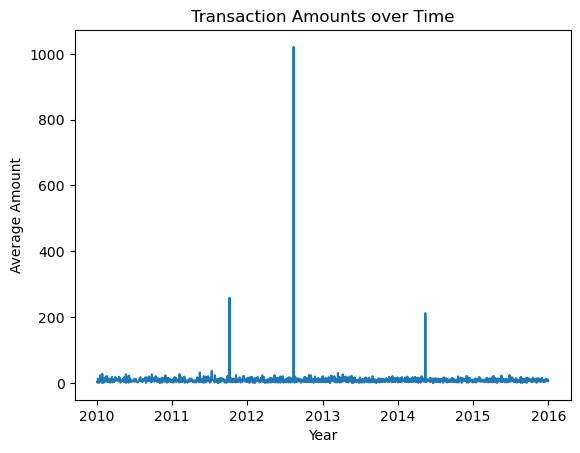

In [36]:
import matplotlib.pyplot as plt

plt.plot(df.groupby("TransactionDate").mean()["Amount"])
plt.xlabel("Year")
plt.ylabel("Average Amount")
plt.title("Transaction Amounts over Time")
plt.show()

There is no clear apparent increase in transaction amounts over time. 

## Step 2

<AxesSubplot:ylabel='Frequency'>

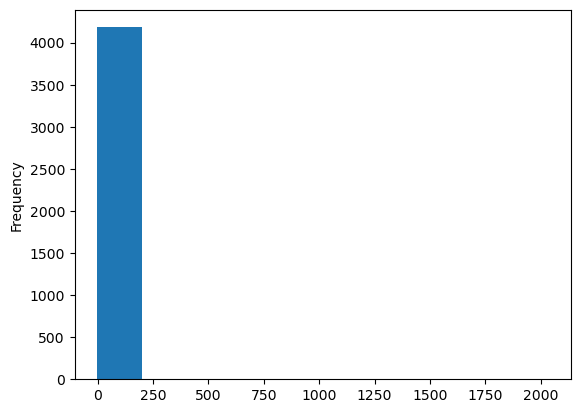

In [37]:
df['Amount'].plot.hist()

In [38]:
import numpy as np

z_scores = np.abs(df["Amount"].sub(df["Amount"].mean()).div(df["Amount"].std()))
outliers = df[z_scores > 3]
print("Outliers in the Amount column:")
print(outliers)

Outliers in the Amount column:
                 TransactionID  CustomerID  Amount
TransactionDate                                   
2011-10-07                  24           7  1003.0
2014-05-14                 212          54  1027.0
2012-08-13                4178        1000  2033.0


1. Yes, there are a few outliers, 3 to be precise.
2. Since the number of outliers is very low compared to the size of the dataset, I would prefer to remove them from the dataset altogether. (script in the next cell)

In [39]:
df = df[z_scores <= 3]

## Step 3

In [40]:
earliest_dates = df.reset_index().groupby('CustomerID')["TransactionDate"].min()

#Extract the year from earliest transaction dates
origin_years = earliest_dates.dt.year

#Create a column with respective origin years of all customers
df['originYear'] = df['CustomerID'].map(origin_years)

## Step 4

In [41]:
grid = {}
days_list = [365, 730, 1095, 1460, 1825, 2190]
mapping = {365:12, 730:24, 1095:36, 1460:48, 1825:60, 2190:72}
years = []
years_list = df.originYear.unique()

for year in years_list:
    years.append(year)
years.sort()
i = len(days_list)
df = df.reset_index()
#To find cumulative amounts for each customer group
for year in years:
    grid[year] = {}
    for days in days_list[:i]:
        block = df.loc[(df['originYear'] == year) & 
                       ((df['TransactionDate'] - pd.to_datetime(str(year)+'-01-01')).dt.days <= days)]
        amt = round(block['Amount'].sum(), 2)
        grid[year][mapping[days]] = amt
    i -= 1

df_grid = pd.DataFrame(grid).transpose()
print("Amount.cmlv\n",df_grid)

Amount.cmlv
            12       24       36       48       60       72
2010  2262.13  3614.78  5274.81  6632.37  7930.69  8964.49
2011  2252.70  3756.90  5464.99  6702.11  7861.24      NaN
2012  2181.35  3874.69  5226.86  6501.85      NaN      NaN
2013  2179.85  3608.81  5226.75      NaN      NaN      NaN
2014  1830.85  3262.05      NaN      NaN      NaN      NaN
2015  1912.17      NaN      NaN      NaN      NaN      NaN


## Step 5

In [42]:
grid_newCust = {}

#To find number of new customers added in each year
for year in years:
    grid_newCust[year] = {}
    nCust = df.loc[df['originYear'] == year].CustomerID.nunique()
    for key in grid[year]:
        grid_newCust[year][key] = int(nCust)
df_newCust = pd.DataFrame(grid_newCust).transpose()
print("NewCustomers.cmltv\n",df_newCust)

NewCustomers.cmltv
          12     24     36     48     60     72
2010  172.0  172.0  172.0  172.0  172.0  172.0
2011  170.0  170.0  170.0  170.0  170.0    NaN
2012  163.0  163.0  163.0  163.0    NaN    NaN
2013  180.0  180.0  180.0    NaN    NaN    NaN
2014  155.0  155.0    NaN    NaN    NaN    NaN
2015  160.0    NaN    NaN    NaN    NaN    NaN


## Step 6

In [43]:
clv = round(df_grid/df_newCust, 2)
print("HistoricCLV\n",clv)

HistoricCLV
          12     24     36     48     60     72
2010  13.15  21.02  30.67  38.56  46.11  52.12
2011  13.25  22.10  32.15  39.42  46.24    NaN
2012  13.38  23.77  32.07  39.89    NaN    NaN
2013  12.11  20.05  29.04    NaN    NaN    NaN
2014  11.81  21.05    NaN    NaN    NaN    NaN
2015  11.95    NaN    NaN    NaN    NaN    NaN


<AxesSubplot:title={'center':'Historic CLV'}, xlabel='Age', ylabel='HistoricCLV'>

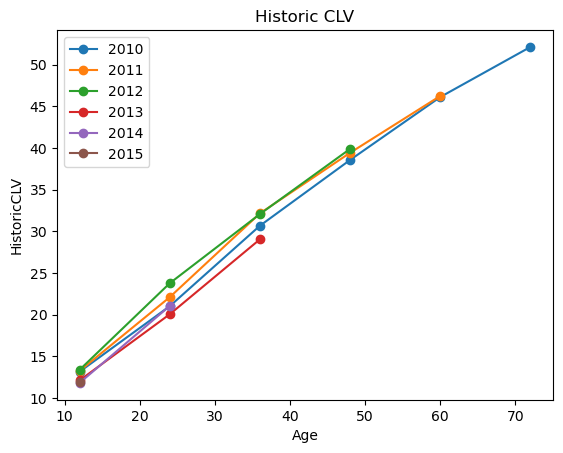

In [44]:
clv.transpose().plot(style="-o", xlabel="Age", ylabel="HistoricCLV", title="Historic CLV")

In [46]:
grid_weighted = {}
for year in grid_newCust:
    grid_weighted[year] = {}
    for age in grid_newCust[year]:
        grid_weighted[year][age] = grid_newCust[year][age] * clv.transpose()[year][age]
df_weighted = pd.DataFrame(grid_weighted).transpose()
weighted = round(df_weighted.sum()/df_newCust.sum(), 2)
print("Single curve of historic CLV")
print(weighted)

Single curve of historic CLV
12    12.62
24    21.57
36    30.94
48    39.28
60    46.17
72    52.12
dtype: float64


## Step 7

In [48]:
print("Customers acquired in 2011 have spent to date $",grid[2011][max(grid[2011])])

Customers acquired in 2011 have spent to date $ 7861.24


In [49]:
print(df_grid)

           12       24       36       48       60       72
2010  2262.13  3614.78  5274.81  6632.37  7930.69  8964.49
2011  2252.70  3756.90  5464.99  6702.11  7861.24      NaN
2012  2181.35  3874.69  5226.86  6501.85      NaN      NaN
2013  2179.85  3608.81  5226.75      NaN      NaN      NaN
2014  1830.85  3262.05      NaN      NaN      NaN      NaN
2015  1912.17      NaN      NaN      NaN      NaN      NaN


From the amount values based on each customer groups, there is a slight downward trend in spending from spending of older customers to spending of newer customers - in each age group. However, this effect is not that prominent. The business should thus, focus on retention of older customers while tending towards acquiring new customers as well.